<a href="https://colab.research.google.com/github/er-Bot/NoteBooks/blob/main/GAN_on_CIFAR10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prequisites

## Keras Conv2D

2D convolutional layers take a three-dimensional input, typically an image with three color channels. They pass a filter, also called a convolution kernel, over the image, inspecting a small window of pixels at a time, for example 3×3 or 5×5 pixels in size, and moving the window until they have scanned the entire image. The convolution operation calculates the dot product of the pixel values in the current filter window with the weights defined in the filter.

![](Group-2.png)

In Keras, you create 2D convolutional layers using the `keras.layers.Conv2D()` function. Unlike in the TensorFlow Conv2D process, you don’t have to define variables or separately construct the activations and pooling, Keras does this automatically for you.

This code sample creates a 2D convolutional layer in Keras.

In [ ]:
keras.layers.Conv2D(
    filters, 
    kernel_size, 
    strides=(1, 1), 
    padding='valid', 
    data_format=None, 
    dilation_rate=(1, 1), 
    activation=None, 
    use_bias=True, 
    kernel_initializer='glorot_uniform', 
    bias_initializer='zeros', 
    kernel_regularizer=None, 
    bias_regularizer=None, 
    activity_regularizer=None, 
    kernel_constraint=None, 
    bias_constraint=None
)

- `filters` : Sets the number of filters used in the convolution operation.	

Earlier 2D convolutional layers, closer to the input, learn less filters, while later convolutional layers, closer to the output, learn more filters. The number of filters you select should depend on the complexity of your dataset and the depth of your neural network. A common setting to start with is $[32, 64, 128, ...]$.


- `kernel_size` : Specifies the size of the convolutional filter in pixels. Must be an odd integer.
keras_conv2d_filter_size.png![](keras_conv2d_filter_size.png)


- `strides=(1, 1)` : The strides parameter is a 2-tuple of integers, specifying how the convolutional filter should “step” along the x and y-axis of the source image.	 (bch7al kank7zo)

In most cases, it’s okay to leave the strides parameter with the default (1, 1). However, you may increase it to (2, 2) to reduce the size of the output volume.

Typically you’ll see strides of 2×2 as a replacement to max pooling:

- `padding='valid'` : The padding parameter has two values:
    - `valid` means the input is not zero-padded, so the output of the convolution will be smaller than the dimensions of the original image. 
    - `same` means the input will be zero-padded, so the convolution output can be the same size as the input.	
 
keras_conv2d_padding.gif![](keras_conv2d_padding.gif)

While the default Keras Conv2D value is `valid` we will typically set it to `same` for the majority of the layers in my network and then either reduce spatial dimensions of my volume by either:

- Max pooling
- Strided convolution

- `data_format=None` : Specifies the order of data in the input received from the backend deep learning framework: `channels_last` or `channels_first`.

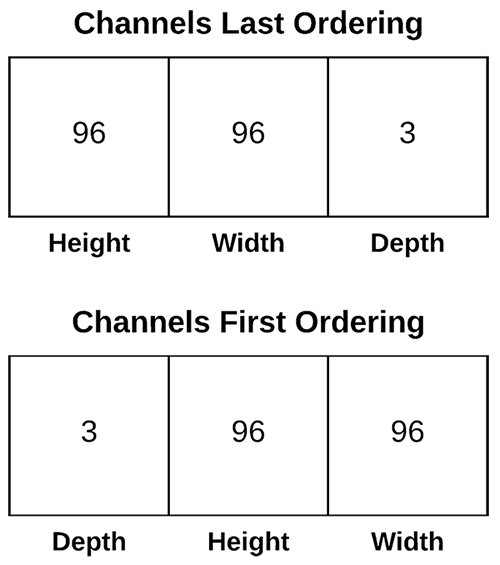![](keras_conv2d_channel_ordering.png)

The TensorFlow backend to Keras uses channels last ordering. Do not change this parameter unless you are using Theano as your backend.

- `dilation_rate=(1, 1)` : A 2-tuple of integers, controlling the dilation rate for dilated convolution. Dilated convolution is a convolution applied to the input volume with defined gaps (the filter does not scan the entire image, skipping certain segments).	

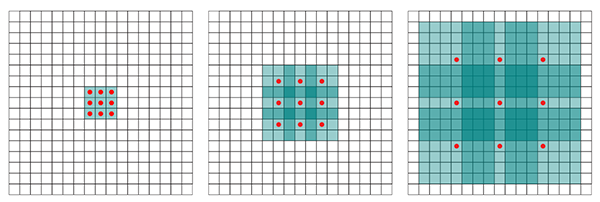![](keras_conv2d_dilation_rate.png)

Dilated convolutions are useful for working with higher resolution images, but wanting to still focus on fine-grained details, or when constructing a network with fewer parameters.

- `activation=None` : The activation parameter specifies the name of the activation function you want to apply after performing the convolution.

keras_conv2d_activation_functions.png![](keras_conv2d_activation_functions.png)

To learn more about activation functions and their impact on your neural network, see our guide to neural network activation functions.

- `use_bias=True` : The use_bias  parameter of the Conv2D class controls whether a bias vector is added to the convolutional layer.	

Typically you’ll want to leave this value as True.

- `kernel_initializer='glorot_uniform'` : The initialization method used to initialize all values in the Conv2D class prior to training.	

The default is `glorot_uniform`, which is Xavier Glorot uniform initialization. This is suitable for most CNNs. For deeper networks, such as VGGnet, you may want to use  `he_normal` which uses the MSRA initialization method.

- `bias_initializer='zeros'` : Controls how the bias vector is initialized before training starts.	

You should typically leave this as the default, zeroes, meaning the bias will be initially filled by zeroes.

- `kernel_regularizer=None`
- `bias_regularizer=None`
- `activity_regularizer=None`: These parameters control the type and amount of regularization. Regularization is a method which helps avoid overfitting and improve the ability of your model to generalize from training examples to a real population.	

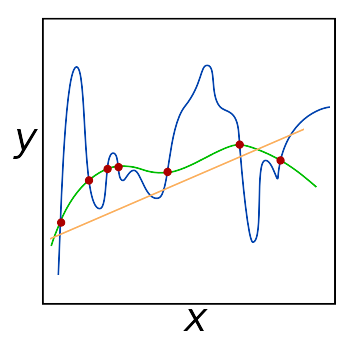![](keras_conv2d_regularization.png)

For large datasets and deep networks, kernel regularization is a must. You can use either L1 or L2 regularization. If you detect signs of overfitting, consider using L2 regularization. Tune the amount of regularization, starting with values of $0.0001 - 0.001$. For bias and activity, we recommend leaving at the default values for most scenarios.

Applying regularization helps you to:

- Reduce the effects of overfitting
- Increase the ability of your model to generalize

- `kernel_constraint=None`
- `bias_constraint=None` : Impose constraints on the Conv2D layer, such as unit normalization, non-negativity, min-max normalization.	

These are advanced settings which should be left at defaults unless you have a special reason to use them in your model.

## Pooling

*Max pooling* and *Average pooling* are the most common pooling functions. Max pooling takes the largest value from the window of the image currently covered by the kernel, while average pooling takes the average of all values in the window.

pooling.gif![](pooling.gif)

# CIFAR-10 Small Object Photograph Dataset

In [ ]:
from keras.datasets.cifar10 import load_data
from matplotlib import pyplot

In [ ]:
# load the images into memory
(trainX, trainy), (testX, testy) = load_data()

# summarize the shape of the dataset
print('Train', trainX.shape, trainy.shape)
print('Test', testX.shape, testy.shape)

In [ ]:
i = 5
# plot raw pixel data
pyplot.imshow(trainX[i]);

In [ ]:
pyplot.figure(figsize=(20, 20))
# plot images from the training dataset
for i in range(49):
    # define subplot
    pyplot.subplot(7, 7, 1 + i)
    # turn off axis
    pyplot.axis('off')
    # plot raw pixel data
    pyplot.imshow(trainX[i])
pyplot.show()

# How to Define and Train the Discriminator Model

- Inputs: Image with three color channel and 32×32 pixels in size.
- Outputs: Binary classification, likelihood the sample is real (or fake).

The discriminator model has a normal convolutional layer followed by three convolutional layers using a stride of 2×2 to downsample the input image. 

The model has ***no pooling layers*** and a single node in the output layer with the sigmoid activation function. 

The model is trained to ***minimize*** the binary cross entropy loss function, appropriate for binary classification.

We will use some best practices in defining the discriminator model, such as the use of ***LeakyReLU*** instead of ReLU, using ***Dropout***, and using the ***Adam*** version of stochastic gradient descent with a learning rate of $0.0002$ and a momentum of $0.5$.

In [ ]:
from numpy import expand_dims
from numpy import ones
from numpy import zeros
from numpy.random import rand
from numpy.random import randint
from numpy.random import randn

from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers import LeakyReLU
from keras.layers import Reshape
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.utils.vis_utils import plot_model

In [ ]:
# define the standalone discriminator model
def define_discriminator(in_shape=(32,32,3)):
    model = Sequential()
    
    # normal   Conv2D(filters, kernel_size, strides, padding,...)
    model.add(Conv2D(64, (3,3), padding='same', input_shape=in_shape))
    model.add(LeakyReLU(alpha=0.2))

    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # downsample
    model.add(Conv2D(128, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # downsample
    model.add(Conv2D(256, (3,3), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # classifier
    model.add(Flatten())
    model.add(Dropout(0.4))
    model.add(Dense(1, activation='sigmoid'))

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [ ]:
# define model
model = define_discriminator()

# summarize the model
model.summary()

In [ ]:
# plot the model
plot_model(model, to_file='discriminator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# load and prepare cifar10 training images
def load_real_samples():
    # load cifar10 dataset
    (trainX, _), (_, _) = load_data()
    # convert from unsigned ints to floats
    X = trainX.astype('float32')
    # scale from [0,255] to [-1,1]
    X = (X - 127.5) / 127.5
    return X

In [ ]:
# select real samples
def generate_real_samples(dataset, n_samples):
    # choose random instances
    ix = randint(0, dataset.shape[0], n_samples)
    # retrieve selected images
    X = dataset[ix]
    # generate 'real' class labels (1)
    y = ones((n_samples, 1))
    return X, y

In [ ]:
# generate n fake samples with class labels
def generate_fake_samples(n_samples):
    # generate uniform random numbers in [0,1]
    X = rand(32 * 32 * 3 * n_samples)
    # update to have the range [-1, 1]
    X = -1 + X * 2
    # reshape into a batch of color images
    X = X.reshape((n_samples, 32, 32, 3))
    # generate 'fake' class labels (0)
    y = zeros((n_samples, 1))
    return X, y

In [ ]:
# train the discriminator model
def train_discriminator(model, dataset, n_iter=20, n_batch=128):
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_iter):
        # get randomly selected 'real' samples
        X_real, y_real = generate_real_samples(dataset, half_batch)
        
        # update discriminator on real samples
        _, real_acc = model.train_on_batch(X_real, y_real)
        
        # generate 'fake' examples
        X_fake, y_fake = generate_fake_samples(half_batch)
        
        # update discriminator on fake samples
        _, fake_acc = model.train_on_batch(X_fake, y_fake)
        
        # summarize performance
        print('>%d real=%.0f%% fake=%.0f%%' % (i+1, real_acc*100, fake_acc*100))

In [ ]:
# load image data
dataset = load_real_samples()

In [ ]:
# fit the model
train_discriminator(model, dataset)

# How to Define and Use the Generator Model

The latent space is an arbitrarily defined vector space of ***Gaussian-distributed*** values, e.g. 100 dimensions. It has no meaning, but by drawing points from this space randomly and providing them to the generator model during training, the generator model will assign meaning to the latent points and, in turn, the latent space, until, at the end of training, the latent vector space represents a compressed representation of the output space, CIFAR-10 images, that only the generator knows how to turn into plausible CIFAR-10 images.

- Inputs: Point in latent space, e.g. a 100-element vector of Gaussian random numbers.
- Outputs: Two-dimensional square color image (3 channels) of 32 x 32 pixels with pixel values in [-1,1].

Developing a generator model requires that we transform a vector from the latent space with, 100 dimensions to a 2D array with 32 x 32 x 3, or 3,072 values.

There are a number of ways to achieve this, but there is one approach that has proven effective on deep convolutional generative adversarial networks. It involves two main elements.

- The first is a ***Dense layer*** as the first hidden layer that has enough nodes to represent a low-resolution version of the output image. Specifically, an image half the size (one quarter the area) of the output image would be 16x16x3, or 768 nodes, and an image one quarter the size (one eighth the area) would be 8 x 8 x 3, or 192 nodes.
   
   With some experimentation, I have found that a smaller low-resolution version of the image works better. Therefore, we will use 4 x 4 x 3, or 48 nodes.
    
    We don’t just want one low-resolution version of the image; we want many parallel versions or interpretations of the input. This is a pattern in convolutional neural networks where we have many parallel filters resulting in multiple parallel activation maps, called ***feature maps***, with different interpretations of the input. We want the same thing in reverse: many parallel versions of our output with different learned features that can be collapsed in the output layer into a final image. The model needs space to invent, create, or generate.

- The next major architectural innovation involves ***upsampling*** the low-resolution image to a higher resolution version of the image.

    There are two common ways to do this upsampling process, sometimes called ***deconvolution****.

    - One way is to use an `UpSampling2D` layer (like a reverse pooling layer) followed by a normal `Conv2D` layer. 
    - The other and perhaps more modern way is to combine these two operations into a single layer, called a `Conv2DTranspose`. We will use this latter approach for our generator.

        The Conv2DTranspose layer can be configured with a stride of (2×2) that will quadruple the area of the input feature maps (double their width and height dimensions). It is also good practice to use a kernel size that is a factor of the stride (e.g. double) to avoid a checkerboard pattern that can sometimes be observed when upsampling.

In [ ]:
# define the standalone generator model
def define_generator(latent_dim):
    model = Sequential()
    
    # foundation for 4x4 image
    n_nodes = 256 * 4 * 4
    model.add(Dense(n_nodes, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Reshape((4, 4, 256)))
    
    # upsample to 8x8
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))
    
    # upsample to 16x16
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # upsample to 32x32
    model.add(Conv2DTranspose(128, (4,4), strides=(2,2), padding='same'))
    model.add(LeakyReLU(alpha=0.2))

    # output layer
    model.add(Conv2D(3, (3,3), activation='tanh', padding='same'))
    return model

In [ ]:
# define the size of the latent space
latent_dim = 100

# define the generator model
model = define_generator(latent_dim)

In [ ]:
# summarize the model
model.summary()
# plot the model
plot_model(model, to_file='generator_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples):
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    
    # reshape into a batch of inputs for the network
    x_input = x_input.reshape(n_samples, latent_dim)
    
    return x_input

In [ ]:
# use the generator to generate n fake examples, with class labels
def generate_fake_samples(g_model, latent_dim, n_samples):
    # generate points in latent space
    x_input = generate_latent_points(latent_dim, n_samples)
    
    # predict outputs
    X = g_model.predict(x_input)

    # create 'fake' class labels (0)
    y = zeros((n_samples, 1))

    return X, y

In [ ]:
# generate samples
n_samples = 49
X, _ = generate_fake_samples(model, latent_dim, n_samples)

# scale pixel values from [-1,1] to [0,1]
X = (X + 1) / 2.0

pyplot.figure(figsize=(20,20))

# plot the generated samples
for i in range(n_samples):
    # define subplot
    pyplot.subplot(7, 7, 1 + i)
    
    # turn off axis labels
    pyplot.axis('off')
    
    # plot single image
    pyplot.imshow(X[i])

# show the figure
pyplot.show()

# How to Train the Generator Model

The weights in the generator model are updated based on the performance of the discriminator model.

When the discriminator is good at detecting fake samples, the generator is updated more, and when the discriminator model is relatively poor or confused when detecting fake samples, the generator model is updated less.

This defines the ***zero-sum*** or adversarial relationship between these two models.

There may be many ways to implement this using the Keras API, but perhaps the simplest approach is to create a new model that combines the generator and discriminator models.

Specifically, a new GAN model can be defined that ***stacks*** the generator and discriminator such that the generator receives as input random points in the latent space and generates samples that are fed into the discriminator model directly, classified, and the output of this larger model can be used to update the model weights of the generator.

To be clear, we are not talking about a new third model, just a new logical model that uses the already-defined layers and weights from the standalone generator and discriminator models.

Only the ***discriminator*** is concerned with distinguishing between real and fake examples, therefore the discriminator model can be trained in a ***standalone*** manner on examples of each, as we did in the section on the discriminator model above.

The ***generator*** model is only concerned with the discriminator’s performance on fake examples. Therefore, we will mark all of the layers in the discriminator as not trainable when it is part of the GAN model so that they can not be updated and overtrained on fake examples.

When training the generator via this logical GAN model, there is one more important change. We want the discriminator to think that the samples output by the generator are real, not fake. Therefore, when the generator is trained as part of the GAN model, we will mark the generated samples as real (class 1).

In [ ]:
# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False

    # connect them
    model = Sequential()
    model.add(g_model)
    model.add(d_model)

    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [ ]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

In [ ]:
# summarize gan model
gan_model.summary()

# plot gan model
plot_model(gan_model, to_file='gan_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
# train the composite model
def train_gan(gan_model, latent_dim, n_epochs=200, n_batch=128):
    # manually enumerate epochs
    for i in range(n_epochs):
        # prepare points in latent space as input for the generator
        x_gan = generate_latent_points(latent_dim, n_batch)

        # create inverted labels for the fake samples
        y_gan = ones((n_batch, 1))

        # update the generator via the discriminator's error
        gan_model.train_on_batch(x_gan, y_gan)

In [ ]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=200, n_batch=256):
    bat_per_epo = int(dataset.shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected 'real' samples
            X_real, y_real = generate_real_samples(dataset, half_batch)

            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch(X_real, y_real)

            # generate 'fake' examples
            X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch)

            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch(X_fake, y_fake)

            # prepare points in latent space as input for the generator
            X_gan = generate_latent_points(latent_dim, n_batch)

            # create inverted labels for the fake samples
            y_gan = ones((n_batch, 1))

            # update the generator via the discriminator's error
            g_loss = gan_model.train_on_batch(X_gan, y_gan)

            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        
        # evaluate the model performance, sometimes
        summarize_performance(i, g_model, d_model, dataset, latent_dim)

# How to Evaluate GAN Model Performance

Generally, there are no objective ways to evaluate the performance of a GAN model.

We cannot calculate this objective error score for generated images.

Instead, images must be subjectively evaluated for quality by a human operator. This means that we cannot know when to stop training without looking at examples of generated images. In turn, the adversarial nature of the training process means that the generator is changing after every batch, meaning that once “good enough” images can be generated, the subjective quality of the images may then begin to vary, improve, or even degrade with subsequent updates.

There are three ways to handle this complex training situation.

1. Periodically evaluate the classification accuracy of the discriminator on real and fake images.
1. Periodically generate many images and save them to file for subjective review.
1. Periodically save the generator model.

All three of these actions can be performed at the same time for a given training epoch, such as every 10 training epochs. The result will be a saved generator model for which we have a way of subjectively assessing the quality of its output and objectively knowing how well the discriminator was fooled at the time the model was saved.

In [ ]:
# evaluate the discriminator, plot generated images, save generator model
def summarize_performance(epoch, g_model, d_model, dataset, latent_dim, n_samples=150):
    # prepare real samples
    X_real, y_real = generate_real_samples(dataset, n_samples)

    # evaluate discriminator on real examples
    _, acc_real = d_model.evaluate(X_real, y_real, verbose=0)

    # prepare fake examples
    x_fake, y_fake = generate_fake_samples(g_model, latent_dim, n_samples)

    # evaluate discriminator on fake examples
    _, acc_fake = d_model.evaluate(x_fake, y_fake, verbose=0)

    # summarize discriminator performance
    print('>Accuracy real: %.0f%%, fake: %.0f%%' % (acc_real*100, acc_fake*100))
    
    # save plot
    save_plot(x_fake, epoch)

    # save the generator model tile file
    filename = 'generator_model_%03d.h5' % (epoch+1)
    g_model.save(filename)

In [ ]:
# create and save a plot of generated images
def save_plot(examples, epoch, n=7):
    # scale from [-1,1] to [0,1]
    examples = (examples + 1) / 2.0

    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)

        # turn off axis
        pyplot.axis('off')

        # plot raw pixel data
        pyplot.imshow(examples[i])
    
    # save plot to file
    filename = 'generated_plot_e%03d.png' % (epoch+1)
    pyplot.savefig(filename)
    pyplot.close()

In [ ]:
# size of the latent space
latent_dim = 100

# create the discriminator
d_model = define_discriminator()

# create the generator
g_model = define_generator(latent_dim)

# create the gan
gan_model = define_gan(g_model, d_model)

In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)